In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np


img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.


In [ ]:
#Define encoder network
#Note that we are using keras functional API
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
#x = layers.Dense(2, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#Sampling from the distributions to obtain latent space
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

encoder = Model(input_img, z)

In [ ]:
#Define decoder network
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [ ]:
def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [ ]:
vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

In [ ]:
vae.summary()
decoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
#load the data and split into train + test sets
(x_train, _), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [17]:
vae.fit(x=x_train,y=x_train, shuffle=True, epochs=5, batch_size=batch_size)  # 5 epochs so it trains in a reasonable time

Epoch 1/5
60000/60000 [==============================] - 392s 7ms/step - loss: 0.2066
Epoch 2/5
60000/60000 [==============================] - 397s 7ms/step - loss: 0.1927
Epoch 3/5
60000/60000 [==============================] - 392s 7ms/step - loss: 0.1884
Epoch 4/5
60000/60000 [==============================] - 395s 7ms/step - loss: 0.1854
Epoch 5/5
60000/60000 [==============================] - 395s 7ms/step - loss: 0.1835


## HOMEWORK 1
Interpolate between two latent vectors (i.e., moving in the latent space) and decode and visualize the interpolations. Provide a code (python notebook) to do this interpolation; and provide 3 interpolated images in-between.

In [83]:
encoded = encoder.predict(x_test)


In [84]:
def interpolate(latent_1, latent_2, n_between=3):
  interpolations = []
  ratios = np.linspace(0, 1, n_between + 2)
  for ratio in ratios[1:-1]:
    interpolated = latent_1 * (1 - ratio) + latent_2 * ratio
    interpolations.append(interpolated.reshape((1, -1)))
  return interpolations

In [85]:
indice_1 = 0
indice_2 = 5
n_between = 3

interpolated = interpolate(encoded[indice_1], encoded[indice_2], n_between=n_between)
decoded = [decoder.predict(encoded[indice_1].reshape((1, -1)))]
decoded.extend([decoder.predict(x) for x in interpolated])
decoded.append(decoder.predict(encoded[indice_2].reshape((1, -1))))

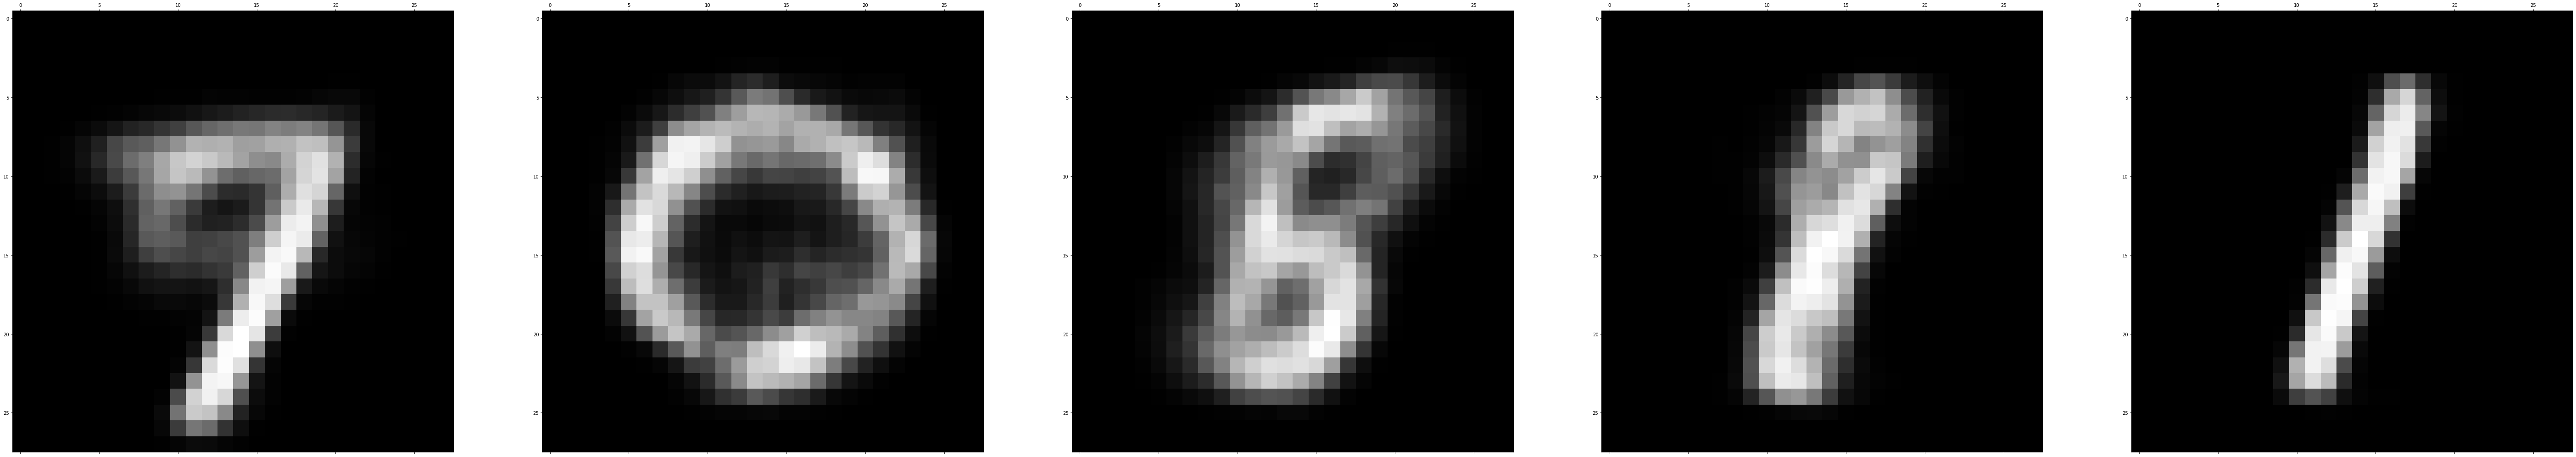

In [86]:
fig, axes = plt.subplots(1, n_between + 2, figsize=(100, 100))
for ax, im in zip(axes, decoded):
  ax.matshow(im[0,:,:,0], cmap='gray')
plt.show()